<h1><center>Laboratorio 9: Optimización de modelos 💯</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos - Primavera 2024</strong></center>

### **Cuerpo Docente:**

- Profesores: Ignacio Meza, Sebastián Tinoco
- Auxiliar: Eduardo Moya
- Ayudantes: Nicolás Ojeda, Melanie Peña, Valentina Rojas

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Junwei He
- Nombre de alumno 2: Sofía Chávez


### **Link de repositorio de GitHub:** [Insertar Repositorio](https://github.com/...../)

### Temas a tratar

- Predicción de demanda usando `xgboost`
- Búsqueda del modelo óptimo de clasificación usando `optuna`
- Uso de pipelines.

### Reglas:

- **Grupos de 2 personas**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.
- Código que no se pueda ejecutar, no será revisado.

### Objetivos principales del laboratorio

- Optimizar modelos usando `optuna`
- Recurrir a técnicas de *prunning*
- Forzar el aprendizaje de relaciones entre variables mediante *constraints*
- Fijar un pipeline con un modelo base que luego se irá optimizando.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# Importamos librerias útiles

In [51]:
!pip install -qq xgboost optuna

# El emprendimiento de Fiu

Tras liderar de manera exitosa la implementación de un proyecto de ciencia de datos para caracterizar los datos generados en Santiago 2023, el misterioso corpóreo **Fiu** se anima y decide levantar su propio negocio de consultoría en machine learning. Tras varias e intensas negociaciones, Fiu logra encontrar su *primera chamba*: predecir la demanda (cantidad de venta) de una famosa productora de bebidas de calibre mundial. Al ver el gran potencial y talento que usted ha demostrado en el campo de la ciencia de datos, Fiu lo contrata como data scientist para que forme parte de su nuevo emprendimiento.

Para este laboratorio deben trabajar con los datos `sales.csv` subidos a u-cursos, el cual contiene una muestra de ventas de la empresa para diferentes productos en un determinado tiempo.

Para comenzar, cargue el dataset señalado y visualice a través de un `.head` los atributos que posee el dataset.

<i><p align="center">Fiu siendo felicitado por su excelente desempeño en el proyecto de caracterización de datos</p></i>
<p align="center">
  <img src="https://media-front.elmostrador.cl/2023/09/A_UNO_1506411_2440e.jpg">
</p>

In [52]:
import pandas as pd
import numpy as np
from datetime import datetime

df = pd.read_csv('sales.csv')

df['date'] = pd.to_datetime(df['date'])

df.head()

<ipython-input-52-c4d8478a1ba8>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
0,0,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,glass,500ml,0.96,13280
1,1,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,plastic,1.5lt,2.86,6727
2,2,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,can,330ml,0.87,9848
3,3,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,adult-cola,glass,500ml,1.00,20050
4,4,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,adult-cola,can,330ml,0.39,25696


In [53]:
df.dtypes

,0
id,int64
date,datetime64[ns]
city,object
lat,float64
long,float64
pop,int64
shop,object
brand,object
container,object
capacity,object


<Axes: >

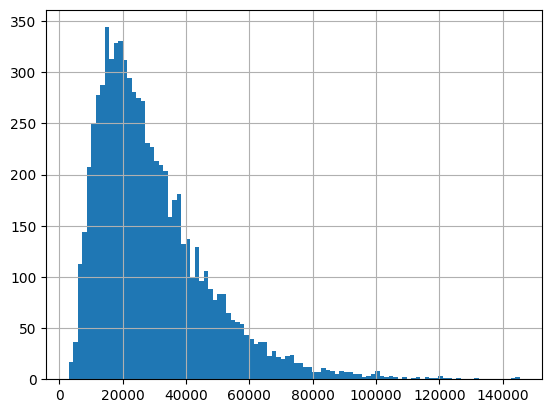

In [54]:
df['quantity'].hist(bins=100)

## 1 Generando un Baseline (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/O-lan6TkadUAAAAC/what-i-wnna-do-after-a-baseline.gif">
</p>

Antes de entrenar un algoritmo, usted recuerda los apuntes de su magíster en ciencia de datos y recuerda que debe seguir una serie de *buenas prácticas* para entrenar correcta y debidamente su modelo. Después de un par de vueltas, llega a las siguientes tareas:

1. Separe los datos en conjuntos de train (70%), validation (20%) y test (10%). Fije una semilla para controlar la aleatoriedad. [0.5 puntos]
2. Implemente un `FunctionTransformer` para extraer el día, mes y año de la variable `date`. Guarde estas variables en el formato categorical de pandas. [1 punto]
3. Implemente un `ColumnTransformer` para procesar de manera adecuada los datos numéricos y categóricos. Use `OneHotEncoder` para las variables categóricas. `Nota:` Utilice el método `.set_output(transform='pandas')` para obtener un DataFrame como salida del `ColumnTransformer` [1 punto]
4. Guarde los pasos anteriores en un `Pipeline`, dejando como último paso el regresor `DummyRegressor` para generar predicciones en base a promedios. [0.5 punto]
5. Entrene el pipeline anterior y reporte la métrica `mean_absolute_error` sobre los datos de validación. ¿Cómo se interpreta esta métrica para el contexto del negocio? [0.5 puntos]
6. Finalmente, vuelva a entrenar el `Pipeline` pero esta vez usando `XGBRegressor` como modelo **utilizando los parámetros por default**. ¿Cómo cambia el MAE al implementar este algoritmo? ¿Es mejor o peor que el `DummyRegressor`? [1 punto]
7. Guarde ambos modelos en un archivo .pkl (uno cada uno) [0.5 puntos]

In [55]:
from sklearn import set_config
set_config(transform_output="pandas")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

SEED = 23952
y = df['quantity']
X = df.drop(columns=['quantity', 'id'])
# Inserte su código acá
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)
X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid, y_test_valid, test_size=2/3, random_state=SEED)
print(f'train size: {X_train.shape[0]}')
print(f'valid size: {X_valid.shape[0]}')
print(f'test size: {X_test.shape[0]}')
print(f'total size: {X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]}')

train size: 5219
valid size: 745
test size: 1492
total size: 7456


In [56]:
date_transformer = FunctionTransformer(
    lambda df: pd.DataFrame({
        'day': df['date'].dt.day.astype('category'),
        'month': df['date'].dt.month.astype('category'),
        'year': df['date'].dt.year.astype('category')
    }), validate=False,
)

In [57]:
date_transformed_train_df = date_transformer.fit_transform(X_train[['date']])
date_transformed_test_df = date_transformer.transform(X_test[['date']])
date_transformed_valid_df = date_transformer.transform(X_valid[['date']])

X_train = X_train.drop(columns=['date'])
X_train['day'] = date_transformed_train_df['day']
X_train['month'] = date_transformed_train_df['month']
X_train['year'] = date_transformed_train_df['year']
X_valid = X_valid.drop(columns=['date'])
X_valid['day'] = date_transformed_valid_df['day']
X_valid['month'] = date_transformed_valid_df['month']
X_valid['year'] = date_transformed_valid_df['year']
X_test = X_test.drop(columns=['date'])
X_test['day'] = date_transformed_test_df['day']
X_test['month'] = date_transformed_test_df['month']
X_test['year'] = date_transformed_test_df['year']


In [58]:
def transform_capacity(df):

  def transform_row(row):
    if row['capacity'].endswith('lt'):
      return float(row['capacity'][:-2]) * 1000
    else:
      return float(row['capacity'][:-2])

  df['capacity'] = df.apply(transform_row, axis=1)
  return df

capacity_transformer = FunctionTransformer(transform_capacity, validate=False)

In [59]:
capacity_transformed_train_df = capacity_transformer.fit_transform(X_train[['capacity']])
capacity_transformed_test_df = capacity_transformer.transform(X_test[['capacity']])
capacity_transformed_valid_df = capacity_transformer.transform(X_valid[['capacity']])

X_train['capacity'] = capacity_transformed_train_df['capacity']
X_valid['capacity'] = capacity_transformed_valid_df['capacity']
X_test['capacity'] = capacity_transformed_test_df['capacity']

<ipython-input-58-0478ea470dc7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['capacity'] = df.apply(transform_row, axis=1)
<ipython-input-58-0478ea470dc7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['capacity'] = df.apply(transform_row, axis=1)
<ipython-input-58-0478ea470dc7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [60]:
transformed_columns = X_train.columns
transformed_columns

Index(['city', 'lat', 'long', 'pop', 'shop', 'brand', 'container', 'capacity',
       'price', 'day', 'month', 'year'],
      dtype='object')

In [61]:
numeric_features = []
categorical_features = []
for col in X_train.columns:
    if X_train[col].dtype == 'category':
        categorical_features.append(col)
    elif X_train[col].dtype == 'object':
        categorical_features.append(col)
    else:
        numeric_features.append(col)

In [62]:
numeric_features

['lat', 'long', 'pop', 'capacity', 'price']

In [63]:
categorical_features

['city', 'shop', 'brand', 'container', 'day', 'month', 'year']

In [64]:
column_transformer = ColumnTransformer(transformers=[
    ('num', 'passthrough', numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
], verbose_feature_names_out=False)
column_transformer.set_output(transform='pandas')

ColumnTransformer(transformers=[('num', 'passthrough',
                                 ['lat', 'long', 'pop', 'capacity', 'price']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['city', 'shop', 'brand', 'container', 'day',
                                  'month', 'year'])],
                  verbose_feature_names_out=False)

In [65]:
pipeline = Pipeline([
    ('preprocess', column_transformer),
    ('model', DummyRegressor())
])

In [66]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['lat', 'long', 'pop',
                                                   'capacity', 'price']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['city', 'shop', 'brand',
                                                   'container', 'day', 'month',
                                                   'year'])],
                                   verbose_feature_names_out=False)),
                ('model', DummyRegressor())])

In [67]:
y_pred_valid = pipeline.predict(X_valid)
mae_dummy_regressor = mean_absolute_error(y_valid, y_pred_valid)
mae_dummy_regressor

13232.473911405279

Considerando la magnitud de la variable quantity, el error absoluto promedio es bastante elevado, por lo que el modelo apenas sirve de baseline.

In [68]:
from xgboost import XGBRegressor
pipeline_xgb = Pipeline([
    ('preprocess', column_transformer),
    ('model', XGBRegressor(random_state=SEED))
])

pipeline_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['lat', 'long', 'pop',
                                                   'capacity', 'price']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['city', 'shop', 'brand',
                                                   'container', 'day', 'month',
                                                   'year'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              c...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=23952, ...))])

In [69]:
y_pred_valid_xgb = pipeline_xgb.predict(X_valid)
mae_xgb = mean_absolute_error(y_valid, y_pred_valid_xgb)
mae_xgb

2561.033100061609

Notamos una mejora considerable en el rendimiento del modelo, disminuyendo en torno al 80% respecto del modelo anterior, siendo un modelo más certero en la predicción de la demanda.

In [70]:
import pickle
# Save the models
with open('dummy_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(pipeline_xgb, f)

## 2. Forzando relaciones entre parámetros con XGBoost (10 puntos)

<p align="center">
  <img src="https://64.media.tumblr.com/14cc45f9610a6ee341a45fd0d68f4dde/20d11b36022bca7b-bf/s640x960/67ab1db12ff73a530f649ac455c000945d99c0d6.gif">
</p>

Un colega aficionado a la economía le *sopla* que la demanda guarda una relación inversa con el precio del producto. Motivado para impresionar al querido corpóreo, se propone hacer uso de esta información para mejorar su modelo realizando las siguientes tareas:

1. Vuelva a entrenar el `Pipeline` con `XGBRegressor`, pero esta vez forzando una relación monótona negativa entre el precio y la cantidad. Para aplicar esta restricción apóyese en la siguiente <a href = https://xgboost.readthedocs.io/en/stable/tutorials/monotonic.html>documentación</a>. [6 puntos]

>Hint 1: Para implementar el constraint se le sugiere hacerlo especificando el nombre de la variable. De ser así, probablemente le sea útil **mantener el formato de pandas** antes del step de entrenamiento.

>Hint 2: Puede obtener el nombre de las columnas en el paso anterior al modelo regresor mediante el método `.get_feature_names_out()`

2. Luego, vuelva a reportar el `MAE` sobre el conjunto de validación. [1 puntos]

3. ¿Cómo cambia el error al incluir esta relación? ¿Tenía razón su amigo? [2 puntos]

4. Guarde su modelo en un archivo .pkl [1 punto]

In [71]:
feature_names = pipeline_xgb['preprocess'].get_feature_names_out()

price_feature_index = list(feature_names).index('price')

monotone_constraints = {}
for i, feature_name in enumerate(feature_names):
    monotone_constraints[feature_name] = -1 if i == price_feature_index else 0

pipeline_xgb_monotonic = Pipeline([
    ('preprocess', column_transformer),
    ('model', XGBRegressor(monotone_constraints=monotone_constraints, random_state=SEED))
])

In [72]:
pipeline_xgb_monotonic.fit(X_train, y_train)
y_pred_valid_xgb_monotonic = pipeline_xgb_monotonic.predict(X_valid)
mae_xgb_monotonic = mean_absolute_error(y_valid, y_pred_valid_xgb_monotonic)
mae_xgb_monotonic

2498.1214991217494

El resultado mejora levemente, lo que podría indicar que el amigo tiene razón, sin embargo, la diferencia es demasiado leve para arrojar una conclusión segura, podría deberse a los conjuntos de datos o sus divisiones en train, test y valid.

In [73]:
with open('xgb_model_monotonic.pkl', 'wb') as f:
    pickle.dump(pipeline_xgb_monotonic, f)

In [74]:
X_train.head()

,city,lat,long,pop,shop,brand,container,capacity,price,day,month,year
6502,Patra,38.24444,21.73444,168034,shop_6,gazoza,plastic,1500.0,1.34,28,2,2018
5960,Patra,38.24444,21.73444,168501,shop_6,adult-cola,glass,500.0,0.98,31,8,2017
2433,Thessaloniki,40.64361,22.93086,349232,shop_4,kinder-cola,glass,500.0,0.68,30,4,2014
1671,Larisa,39.63689,22.41761,139242,shop_5,lemon-boost,glass,500.0,1.14,31,7,2013
6881,Athens,37.96245,23.68708,664046,shop_3,orange-power,can,330.0,0.42,30,6,2018


In [75]:
X_train_backup = X_train.copy()
X_valid_backup = X_valid.copy()
X_test_backup = X_test.copy()
y_train_backup = y_train.copy()
y_valid_backup = y_valid.copy()
y_test_backup = y_test.copy()

## 1.3 Optimización de Hiperparámetros con Optuna (20 puntos)

<p align="center">
  <img src="https://media.tenor.com/fmNdyGN4z5kAAAAi/hacking-lucy.gif">
</p>

Luego de presentarle sus resultados, Fiu le pregunta si es posible mejorar *aun más* su modelo. En particular, le comenta de la optimización de hiperparámetros con metodologías bayesianas a través del paquete `optuna`. Como usted es un aficionado al entrenamiento de modelos de ML, se propone implementar la descabellada idea de su jefe.

A partir de la mejor configuración obtenida en la sección anterior, utilice `optuna` para optimizar sus hiperparámetros. En particular, se pide que su optimización considere lo siguiente:

- Fijar una semilla en las instancias necesarias para garantizar la reproducibilidad de resultados
- Utilice `TPESampler` como método de muestreo
- De `XGBRegressor`, optimice los siguientes hiperparámetros:
    - `learning_rate` buscando valores flotantes en el rango (0.001, 0.1)
    - `n_estimators` buscando valores enteros en el rango (50, 1000)
    - `max_depth` buscando valores enteros en el rango (3, 10)
    - `max_leaves` buscando valores enteros en el rango (0, 100)
    - `min_child_weight` buscando valores enteros en el rango (1, 5)
    - `reg_alpha` buscando valores flotantes en el rango (0, 1)
    - `reg_lambda` buscando valores flotantes en el rango (0, 1)
- De `OneHotEncoder`, optimice el hiperparámetro `min_frequency` buscando el mejor valor flotante en el rango (0.0, 1.0)

Para ello se pide los siguientes pasos:
1. Implemente una función `objective()` que permita minimizar el `MAE` en el conjunto de validación. Use el método `.set_user_attr()` para almacenar el mejor pipeline entrenado. [10 puntos]
2. Fije el tiempo de entrenamiento a 5 minutos. [1 punto]
3. Optimizar el modelo y reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto? [3 puntos]
4. Explique cada hiperparámetro y su rol en el modelo. ¿Hacen sentido los rangos de optimización indicados? [5 puntos]
5. Guardar su modelo en un archivo .pkl [1 punto]

In [76]:
import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Inserte su código acá

def objective(trial):
    # Params
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    max_leaves = trial.suggest_int("max_leaves", 0, 100)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 5)
    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 1.0)
    reg_lambda = trial.suggest_float("reg_lambda", 0.0, 1.0)
    min_frequency = trial.suggest_float("min_frequency", 0.0, 1.0)

    # Configure ColumnTransformer
    column_transformer = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numeric_features),
            ('cat', OneHotEncoder(min_frequency=min_frequency, sparse_output=False), categorical_features),
        ], verbose_feature_names_out=False)
    column_transformer.set_output(transform='pandas')

    column_transformer.fit(X_train)
    transformed_feature_names = column_transformer.get_feature_names_out()
    price_feature_index = list(transformed_feature_names).index('price')
    monotone_constraints = {name: -1 if i == price_feature_index else 0 for i, name in enumerate(transformed_feature_names)}

    # pipeline
    model = Pipeline([
        ('preprocess', column_transformer),
        ('model', XGBRegressor(
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_leaves=max_leaves,
            min_child_weight=min_child_weight,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            monotone_constraints=monotone_constraints,
            random_state=SEED,
            n_jobs=-1
        ))
    ])

    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)

    trial.set_user_attr("best_model", model)

    return mae

In [92]:
sampler = TPESampler(seed=SEED)

study = optuna.create_study(
    direction="minimize",
    sampler=sampler
)

study.optimize(objective, timeout=300)


[W 2024-10-26 02:57:34,929] Trial 0 failed with parameters: {'learning_rate': 0.01255533233680171, 'n_estimators': 594, 'max_depth': 8, 'max_leaves': 62, 'min_child_weight': 4, 'reg_alpha': 0.4329039327938101, 'reg_lambda': 0.18889251231770587, 'min_frequency': 0.8694147195337786} because of the following error: XGBoostError('[02:57:34] /workspace/src/data/iterative_dmatrix.cc:93: Check failed: ref->Info().num_col_ == n_features (47 vs. 12) : Invalid ref DMatrix, different number of features.\nStack trace:\n  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x22dbbc) [0x7f343602dbbc]\n  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x518a66) [0x7f3436318a66]\n  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x51aac1) [0x7f343631aac1]\n  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x51d82c) [0x7f343631d82c]\n  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/

XGBoostError: [02:57:34] /workspace/src/data/iterative_dmatrix.cc:93: Check failed: ref->Info().num_col_ == n_features (47 vs. 12) : Invalid ref DMatrix, different number of features.
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x22dbbc) [0x7f343602dbbc]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x518a66) [0x7f3436318a66]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x51aac1) [0x7f343631aac1]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x51d82c) [0x7f343631d82c]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4cce3a) [0x7f34362cce3a]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x18c) [0x7f3435f4546c]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f34971e0e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f34971dd493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f34972063e9]



In [78]:
best_trial = study.best_trial
print(f"N intentos: {len(study.trials)}")
print(f"mejor MAE: {best_trial.value}")
print("mejores hiperparametros:")
for key, value in best_trial.params.items():
    print(f"{key}: {value}")

best_model = best_trial.user_attrs["best_model"]


N intentos: 136
mejor MAE: 1987.5450523018037
mejores hiperparametros:
learning_rate: 0.05367621806980898
n_estimators: 985
max_depth: 8
max_leaves: 92
min_child_weight: 5
reg_alpha: 0.2387640823603054
reg_lambda: 0.5998736632613274
min_frequency: 0.07366724108866288


Los resultados mejoran considerablemente, reduciendo el MAE a un 80% del mejor resultado hasta ahora.

Esto se debe en primer lugar al aumento de la cantidad de parámetros probados, pero también puede tener efecto la transformación realizada al conjunto de entrenamiento. Cabe mencionar que probamos con distintos parámetros que ya incorporaban la restricción entre cantidad y precio, por lo que era de esperar que los resultados fueran a lo menos similares.

Respecto a los parámetros:
* Learning rate: el tamaño de cada "salto" o "avance" en la optimización de los parámetros con gradient boosting. Define la magnitud del ajuste que cada nuevo árbol aporta al modelo.
* n_estimators: la cantidad de árboles ajustados para el gradient boosting.
* max_depth: profundidad máxima de los árboles
* max_leaves: cantidad máxima de hojas de los árboles
* min_child_weight: threshold bajo el cual un nodo deja de dividirse. Para ello computa la suma de los pesos (hesianos) de un nodo entre las instancias que llegan a él. Es similar a la cantidad mínima de instancias por nodo en un árbol clásico.
* reg_alpha: regularización con norma L1 (Lasso) sobre los pesos, sirve para evitar el sobreajuste al favorecer un modelo más conservador.
* reg_lambda: similar a la reg_alpha pero con norma L2.
* min_frequency: define la frecuencia mínima que debe tener una categoría para ser considerada, aquellas que presentan menos instancias de las requeridas son agrupadas como una categoría conjunta.


- Los rangos de optmización fueron:
    - `learning_rate`: (0.001, 0.1). Son rangos estándar utilizados.
    - `n_estimators`: (50, 1000). Tiene sentido considerando que los árboles son weak learners, haber disminuido el valor mínimo difícilmente habría producido mejores resultados. Como el conjunto de train es del orden de 5000 y el óptimo se alcanzó cerca a los 1000, aumentar el valor máximo tampoco es de esperar que mejore los resultados, debido a un sobreajuste.
    - `max_depth`: (3, 10). Es análogo al caso anterior, tener árboles de profundidad máxima 2 no tendría mejores resultados, y aumentarlos no pareciera que mejore los resultados, considerando que el óptimo se alcanzó en 8. Se podría probar con valores mayores, pero contradice la idea de tener weak learners.
    - `max_leaves`: (0, 100). Considerando que la cantidad óptima se alcanzó en 92 tendría sentido explorar un rango mayor. Se podría probar sin necesariamente aumentar la profundidad máxima, considerando que un árbol balanceado de produndidad 10 tiene 1024 hojas.
    - `min_child_weight`: (1, 5). Dado que el óptimo se alcanzó en 5 resulta necesario probar con valores mayores, el rango está muy limitado.
    - `reg_alpha` y `reg_lambda` (0, 1): el óptimo de ambas regularizaciones se alcanzó lejos de sus valores límites, por lo cual parece estar bien definido el rango.
    - `OneHotEncoder: min_frequency` (0.0, 1.0): se probó con todo el rango posible, se pudo haber acotado considerando que un threshold de 50% restringe a 2 categorías y que valores sobre 1/número de categorías comienzan a ignorarlas abruptamente.

In [79]:
with open('xgb_model_optuna.pkl', 'wb') as f:
    pickle.dump(best_model, f)

## 4. Optimización de Hiperparámetros con Optuna y Prunners (17 puntos)

<p align="center">
  <img src="https://i.pinimg.com/originals/90/16/f9/9016f919c2259f3d0e8fe465049638a7.gif">
</p>

Después de optimizar el rendimiento de su modelo varias veces, Fiu le pregunta si no es posible optimizar el entrenamiento del modelo en sí mismo. Después de leer un par de post de personas de dudosa reputación en la *deepweb*, usted llega a la conclusión que puede cumplir este objetivo mediante la implementación de **Prunning**.

Vuelva a optimizar los mismos hiperparámetros que la sección pasada, pero esta vez utilizando **Prunning** en la optimización. En particular, usted debe:

- Responder: ¿Qué es prunning? ¿De qué forma debería impactar en el entrenamiento? [2 puntos]
- Redefinir la función `objective()` utilizando `optuna.integration.XGBoostPruningCallback` como método de **Prunning** [10 puntos]
- Fijar nuevamente el tiempo de entrenamiento a 5 minutos [1 punto]
- Reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto? [3 puntos]
- Guardar su modelo en un archivo .pkl [1 punto]

Nota: Si quieren silenciar los prints obtenidos en el prunning, pueden hacerlo mediante el siguiente comando:

```
optuna.logging.set_verbosity(optuna.logging.WARNING)
```

De implementar la opción anterior, pueden especificar `show_progress_bar = True` en el método `optimize` para *más sabor*.

Hint: Si quieren especificar parámetros del método .fit() del modelo a través del pipeline, pueden hacerlo por medio de la siguiente sintaxis: `pipeline.fit(stepmodelo__parametro = valor)`

Hint2: Este <a href = https://stackoverflow.com/questions/40329576/sklearn-pass-fit-parameters-to-xgboost-in-pipeline>enlace</a> les puede ser de ayuda en su implementación

Prunning es poda de árboles, es el proceso mediante el cual se eliminan hojas que aportan poca información, dependiendo del criterio de ajuste del árbol. Su impacto en el entrenamiento es un aumento de la capacidad del modelo de generalizar y la reducción de su tamaño, obteniendo un modelo más simple y rápido de ejecutar.

In [80]:
!pip install optuna-integration[xgboost]

In [81]:
X_train.head()

,city,lat,long,pop,shop,brand,container,capacity,price,day,month,year
6502,Patra,38.24444,21.73444,168034,shop_6,gazoza,plastic,1500.0,1.34,28,2,2018
5960,Patra,38.24444,21.73444,168501,shop_6,adult-cola,glass,500.0,0.98,31,8,2017
2433,Thessaloniki,40.64361,22.93086,349232,shop_4,kinder-cola,glass,500.0,0.68,30,4,2014
1671,Larisa,39.63689,22.41761,139242,shop_5,lemon-boost,glass,500.0,1.14,31,7,2013
6881,Athens,37.96245,23.68708,664046,shop_3,orange-power,can,330.0,0.42,30,6,2018


In [89]:
X_train = X_train_backup.copy()
X_valid = X_valid_backup.copy()
X_test = X_test_backup.copy()
y_train = y_train_backup.copy()
y_valid = y_valid_backup.copy()

def objective(trial):
    # Params
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    max_leaves = trial.suggest_int("max_leaves", 0, 100)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 5)
    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 1.0)
    reg_lambda = trial.suggest_float("reg_lambda", 0.0, 1.0)
    min_frequency = trial.suggest_float("min_frequency", 0.0, 1.0)

    for col in X_train.columns:
        if X_train[col].dtype == 'object':
            X_train[col] = X_train[col].astype('category')
            X_valid[col] = X_valid[col].astype('category')

    '''
    for categorical_col in X_train.select_dtypes(include=['category']):
        train_categories = set(X_train[categorical_col].cat.categories)
        valid_categories = set(X_valid[categorical_col].cat.categories)
        all_categories = train_categories.union(valid_categories)
        X_train[categorical_col].cat.set_categories(all_categories)
        X_valid[categorical_col].cat.set_categories(all_categories)
        X_train[categorical_col] = pd.Categorical(X_train[categorical_col], categories=all_categories)
        X_valid[categorical_col] = pd.Categorical(X_valid[categorical_col], categories=all_categories) '''


    # Configure ColumnTransformer
    column_transformer = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numeric_features),
            ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features),
        ], verbose_feature_names_out=False)
    column_transformer.set_output(transform='pandas')

    column_transformer.fit(X_train)
    transformed_feature_names = column_transformer.get_feature_names_out()
    price_feature_index = list(transformed_feature_names).index('price')
    monotone_constraints = {name: -1 if i == price_feature_index else 0 for i, name in enumerate(transformed_feature_names)}

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-mae")
    # pipeline
    pipeline = Pipeline([
        ('preprocess', column_transformer),
        ('model', XGBRegressor(
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_leaves=max_leaves,
            min_child_weight=min_child_weight,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            monotone_constraints=monotone_constraints,
            random_state=SEED,
            n_jobs=-1,
            callbacks=[pruning_callback],
            enable_categorical=True
        ))
    ])


    pipeline.fit(X_train,
              y_train,
              model__eval_set=[(X_valid, y_valid)],
              model__verbose=False)

    y_pred = pipeline.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)

    trial.set_user_attr("best_model", pipeline)

    return mae


sampler = TPESampler(seed=SEED)

pruning_study = optuna.create_study(
    direction="minimize",
    sampler=sampler
)

pruning_study.optimize(objective, timeout=300, show_progress_bar=True)

   0%|          | 00:00/05:00

[W 2024-10-26 02:55:23,649] Trial 0 failed with parameters: {'learning_rate': 0.01255533233680171, 'n_estimators': 594, 'max_depth': 8, 'max_leaves': 62, 'min_child_weight': 4, 'reg_alpha': 0.4329039327938101, 'reg_lambda': 0.18889251231770587, 'min_frequency': 0.8694147195337786} because of the following error: XGBoostError('[02:55:23] /workspace/src/data/iterative_dmatrix.cc:93: Check failed: ref->Info().num_col_ == n_features (47 vs. 12) : Invalid ref DMatrix, different number of features.\nStack trace:\n  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x22dbbc) [0x7f343602dbbc]\n  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x518a66) [0x7f3436318a66]\n  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x51aac1) [0x7f343631aac1]\n  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x51d82c) [0x7f343631d82c]\n  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/

XGBoostError: [02:55:23] /workspace/src/data/iterative_dmatrix.cc:93: Check failed: ref->Info().num_col_ == n_features (47 vs. 12) : Invalid ref DMatrix, different number of features.
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x22dbbc) [0x7f343602dbbc]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x518a66) [0x7f3436318a66]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x51aac1) [0x7f343631aac1]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x51d82c) [0x7f343631d82c]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4cce3a) [0x7f34362cce3a]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x18c) [0x7f3435f4546c]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f34971e0e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f34971dd493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f34972063e9]



In [ ]:
best_trial = pruning_study.best_trial
print(f"N intentos: {len(pruning_study.trials)}")
print(f"mejor MAE: {best_trial.value}")
print("mejores hiperparametros:")
for key, value in best_trial.params.items():
    print(f"{key}: {value}")

best_model = best_trial.user_attrs["best_model"]

with open('xgb_model_optuna_prunning.pkl', 'wb') as f:
    pickle.dump(best_model, f)

## 5. Visualizaciones (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/F-LgB1xTebEAAAAd/look-at-this-graph-nickelback.gif">
</p>


Satisfecho con su trabajo, Fiu le pregunta si es posible generar visualizaciones que permitan entender el entrenamiento de su modelo.

A partir del siguiente <a href = https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#visualization>enlace</a>, genere las siguientes visualizaciones:

1. Gráfico de historial de optimización [1 punto]
2. Gráfico de coordenadas paralelas [1 punto]
3. Gráfico de importancia de hiperparámetros [1 punto]

Comente sus resultados:

4. ¿Desde qué *trial* se empiezan a observar mejoras notables en sus resultados? [0.5 puntos]
5. ¿Qué tendencias puede observar a partir del gráfico de coordenadas paralelas? [1 punto]
6. ¿Cuáles son los hiperparámetros con mayor importancia para la optimización de su modelo? [0.5 puntos]

In [85]:
# Inserte su código acá
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_param_importances
plot_optimization_history(study)

[W 2024-10-26 02:54:20,690] There are no complete trials.


In [90]:
plot_parallel_coordinate(study)

[W 2024-10-26 02:55:55,985] Your study does not have any completed trials.


In [87]:
plot_param_importances(study)

[W 2024-10-26 02:54:26,471] Study instance does not contain completed trials.


## 6. Síntesis de resultados (3 puntos)

Finalmente:

1. Genere una tabla resumen del MAE en el conjunto de validación obtenido en los 5 modelos entrenados desde Baseline hasta XGBoost con Constraints, Optuna y Prunning. [1 punto]
2. Compare los resultados de la tabla y responda, ¿qué modelo obtiene el mejor rendimiento? [0.5 puntos]
3. Cargue el mejor modelo, prediga sobre el conjunto de **test** y reporte su MAE. [0.5 puntos]
4. ¿Existen diferencias con respecto a las métricas obtenidas en el conjunto de validación? ¿Porqué puede ocurrir esto? [1 punto]

In [91]:
# Inserte su código acá


data = {
    'Modelo': ['Baseline','XGBoost', 'XGBoost Constraints', 'XGBoost Optuna', 'XGBoost Optuna Prunning'],
    'MAE (Validación)': [mae_dummy_regressor,mae_xgb, mae_xgb_monotonic, best_trial.value, best_trial.value]
}

df_mae = pd.DataFrame(data)
print(df_mae)

                    Modelo  MAE (Validación)
0                 Baseline      13232.473911
1                  XGBoost       2561.033100
2      XGBoost Constraints       2498.121499
3           XGBoost Optuna       1987.545052
4  XGBoost Optuna Prunning       1987.545052


El modelo que obtiene mejor resultado es el XGboost con Optuna, No pudimos correr el XGBoost con optuna y prunning por un mismatch en las columnas de los datasets de train y valid, probablemente debido a la ausencia de categorías entre ellos.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

<p align="center">
  <img src="https://media.tenor.com/8CT1AXElF_cAAAAC/gojo-satoru.gif">
</p>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>